In [1]:
import numpy as np
import matplotlib.pylab as plt
%matplotlib inline

500 samples for train and 1500 for testing


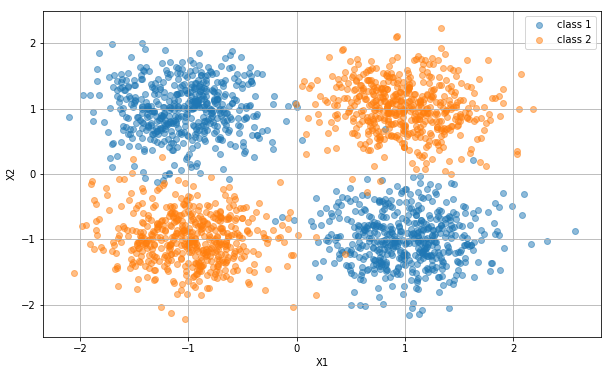

In [2]:
def create_noisy_xor(N_per_cluster=500, stddev_noise=0.4):
    data = stddev_noise*np.random.randn(4*N_per_cluster, 2)
    data[0*N_per_cluster:1*N_per_cluster, :] += [1.0, -1.0]
    data[1*N_per_cluster:2*N_per_cluster, :] += [-1.0, 1.0]
    data[2*N_per_cluster:3*N_per_cluster :] += [-1.0, -1.0]
    data[3*N_per_cluster:4*N_per_cluster, :] += [1.0, 1.0]
    #data = (data - np.mean(X, axis=0))/np.std(X, axis=0)
    labels = np.zeros(shape=(4*N_per_cluster,), dtype=int)
    labels[2*N_per_cluster:] = 1.0
    NP = np.random.permutation(4*N_per_cluster)
    return data[NP, :], labels[NP]

# Create training and test set
data , labels = create_noisy_xor()
data_train, labels_train = data[:500, :], labels[:500]
data_test, labels_test = data[500:, :], labels[500:]
print("%d samples for train and %d for testing" %(len(data_train), len(data)-len(data_train)))
# Plot data
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(1, 1, 1)
ax.scatter(data[labels==0, 0], data[labels==0, 1], marker='o', label="class 1", alpha=0.5)
ax.scatter(data[labels==1, 0], data[labels==1, 1], marker='o', label="class 2", alpha=0.5)
ax.grid()
ax.set_xlabel('X1')
ax.set_ylabel('X2')
plt.legend();

In [3]:
def logistic(z):
    return 1.0/(1.0 + np.exp(-z))

class MLP:
    
    def __init__(self, input_dim=2, hidden_dim=10, rstate=None):
        np.random.seed(rstate)
        self.hidden_dim = hidden_dim
        output_dim = 1 # Only for binary classification or single variable regression
        if hidden_dim > 0:
            self.wh = np.random.randn(input_dim, hidden_dim)
            self.bh = np.random.randn(hidden_dim)
            self.wo = np.random.randn(hidden_dim, output_dim)
        else:
            self.wo = np.random.randn(input_dim, output_dim)
        self.bo = np.random.randn(output_dim)

    def forward(self, x):
        if self.hidden_dim > 0:
            z = np.tanh(np.dot(x, self.wh) + self.bh)
        else:
            z = x
        return logistic(np.dot(z, self.wo) + self.bo)
        
    def score(self, x, y):        
        ypred = self.forward(x)[:, 0] # Binary classification
        #return 0.5*np.power(y - ypred, 2)
        return -y*np.log(ypred) - (1.0-y)*np.log(1.0-ypred)
    
    def backward(self, x, y, eta=1e-2):
        ypred = self.forward(x)
        #error = -(y - ypred)  # MSE plus linear activation
        #error = -(y - ypred)*ypred*(1.0 - ypred)  # MSE plus sigmoid activation
        error = -(y - ypred)  # Cross-entropy plus sigmoid activation
        dbo = np.sum(error, axis=0)        
        if self.hidden_dim > 0:
            z_linear = np.dot(x, self.wh) + self.bh
            dwo = np.dot(np.tanh(z_linear).T, error)
            grad_z = (1.0 - np.tanh(z_linear)**2)
            dbh = np.dot(grad_z.T, error)[:, 0]
            dwh = np.dot(x.T, error*grad_z)
            self.wh -= eta*dwh
            self.bh -= eta*dbh
        else:
            dwo = np.dot(x.T, error)
        self.bo -= eta*dbo
        self.wo -= eta*dwo

# Modifique la red para hacer regresión en ves de clasificación
# Modifique la red para usar sigmoide en vez de tangente hiperbólica en la capa oculta

In [4]:
nnet = MLP(hidden_dim=1)
cost_history_train = list()
cost_history_test = list()
k = 1

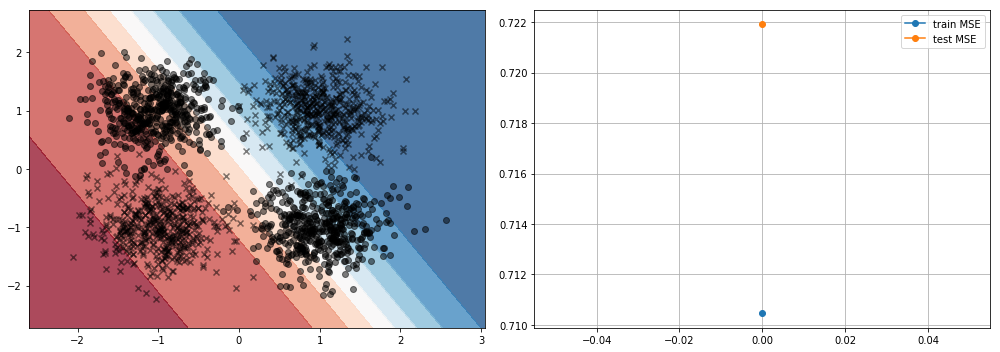

In [5]:
# Minibatch training, only one epoch
for epoch in range(1):
    for i in range(len(data_train)//10):
        nnet.backward(data_train[i*10:(i+1)*10, :], labels_train[i*10:(i+1)*10, np.newaxis], eta=1e-2)
    
fig = plt.figure(figsize=(14, 5))
ax = fig.add_subplot(1, 2, 1)
x_min, x_max = data[:, 0].min() - 0.5, data[:, 0].max() + 0.5
y_min, y_max = data[:, 1].min() - 0.5, data[:, 1].max() + 0.5
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.05), np.arange(y_min, y_max, 0.05))
Z = nnet.forward(np.c_[xx.ravel(), yy.ravel()])[:,0]
Z = Z.reshape(xx.shape)
ax.contourf(xx, yy, Z, cmap=plt.cm.RdBu_r, alpha=0.75)
ax.scatter(data[labels==0, 0], data[labels==0, 1], color='k', marker='o', alpha=0.5)
ax.scatter(data[labels==1, 0], data[labels==1, 1], color='k', marker='x', alpha=0.5)
ax = fig.add_subplot(1, 2, 2)
cost_history_train.append(np.mean(nnet.score(data_train, labels_train)))
cost_history_test.append(np.mean(nnet.score(data_test, labels_test)))
ax.plot(np.arange(0, k, step=1), cost_history_train, '-o', label="train MSE")
ax.plot(np.arange(0, k, step=1), cost_history_test, '-o', label="test MSE")
plt.legend()
plt.grid()
plt.tight_layout()
k+=1

**Ejercicios**
- Experimente variando el número de capas, número de neuronas y tasa de aprendizaje. Comente sobre como se reflejan estas modificaciones en el desempeño de la red y en la  complejidad del hiperplano
- Experimente aumentando el ruido de los datos
- Discuta sobre la relación entre complejidad del hiperplano, capacidad de generalización y sobreajuste

## Implementación usando tensorflow

In [6]:
import tensorflow as tf
import time
from os.path import join

tf.reset_default_graph()
tf_input = tf.placeholder(tf.float32, [None, 2], name='input')
tf_label = tf.placeholder(tf.float32, [None, 1], name='target')

Nh = 10
nepochs = 500  

with tf.variable_scope('Hidden_layer'):
    bh = tf.Variable(tf.zeros([Nh]), name="bias", dtype=tf.float32)
    wh = tf.Variable(tf.random_uniform([2, Nh], -1.0, 1.0), name="weight", dtype=tf.float32)
    z = tf.nn.tanh(tf.matmul(tf_input, wh) + bh)

with tf.variable_scope('Output_layer'):
    bo = tf.Variable(tf.zeros([1]), name="bias", dtype=tf.float32)
    wo = tf.Variable(tf.random_uniform([Nh, 1], -1.0, 1.0), name="weight", dtype=tf.float32)
    y = tf.add(tf.matmul(z, wo), bo)

with tf.variable_scope('Optimizer'):
    cross_entropy = tf.nn.sigmoid_cross_entropy_with_logits(labels=tf_label, logits=y)
    loss_op = tf.reduce_mean(cross_entropy)  
    optimizer = tf.train.AdamOptimizer(1e-2)
    train_op = optimizer.minimize(loss_op) 
    init = tf.global_variables_initializer()

with tf.name_scope('summaries'):
    tf.summary.scalar('loss', loss_op)
    tf.summary.histogram('output_weight', wo)
    tf.summary.histogram('output_bias', bo)

merged = tf.summary.merge_all()
    
log_dir = join("/tmp/tensorboard/", str(time.time()))

**Ejercicios:** 
- Visualice el grafo, las curvas de aprendizaje y los histogramas de parámetros usando la herramienta tensorboard
- Modifique el código que genera el grafo para agregar una segunda capa oculta
- Estudie la función de mayor abstracción tf.layers.dense y usela para modificar el código que genera el grafo
- ¿Cómo modificaría el código de entrenamiento para usar mini-batches?

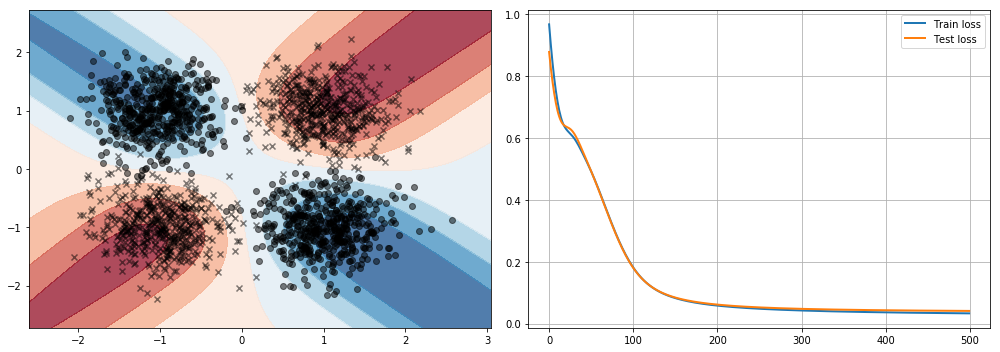

In [7]:
with tf.Session() as sess:
    train_writer = tf.summary.FileWriter(join(log_dir, 'train'), sess.graph)
    test_writer = tf.summary.FileWriter(join(log_dir, 'test'), sess.graph)
    sess.run(init)
    train_loss = np.zeros(shape=(nepochs))
    test_loss = np.zeros(shape=(nepochs))
    for i, epoch in enumerate(range(nepochs)):
        # run the training operation
        _, train_loss[i], summary = sess.run([train_op, loss_op, merged], feed_dict={tf_input: data_train, 
                                                         tf_label: np.reshape(labels_train, [-1, 1])})
        train_writer.add_summary(summary, i)
        pred_test, test_loss[i], summary = sess.run([y, loss_op, merged], feed_dict={tf_input: data_test, 
                                                                 tf_label: np.reshape(labels_test, [-1, 1])})
        test_writer.add_summary(summary, i)

    Z = sess.run(y, feed_dict={tf_input: (np.c_[xx.ravel(), yy.ravel()]).astype('float32')})
    Z = Z.reshape(xx.shape)

fig = plt.figure(figsize=(14, 5))
ax = fig.add_subplot(1, 2, 1)
ax.contourf(xx, yy, Z, cmap=plt.cm.RdBu_r, alpha=0.75)
ax.scatter(data[labels==0, 0], data[labels==0, 1], color='k', marker='o', alpha=0.5)
ax.scatter(data[labels==1, 0], data[labels==1, 1], color='k', marker='x', alpha=0.5)
ax = fig.add_subplot(1, 2, 2)
ax.plot(train_loss, label='Train loss', linewidth=2)
ax.plot(test_loss, label='Test loss', linewidth=2)
plt.grid()
plt.legend()
plt.tight_layout();

- Tensorboard: análisis del grafo, curvas de aprendizaje, histograma de parámetros

## Implementación usando pytorch

**Ejercicio:** Modifique la clase para agregando una segunda capa oculta

In [8]:
import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset 

class myMLP(torch.nn.Module):

    def __init__(self, dim_input, dim_hidden=50, dim_classes=1):        
        
        super(myMLP, self).__init__()
        
        self.fc1 = torch.nn.Linear(in_features=dim_input,  out_features=dim_hidden, bias=True)
        self.fc2 = torch.nn.Linear(in_features=dim_hidden, out_features=dim_classes, bias=True)
        
    def forward(self, x):
        z = F.tanh(self.fc1(x))
        y = self.fc2(z)
        return y

**Ejercicio:** Modifique el siguiente código para correr en GPU. 

Por qué no se ve un speed-up considerable en este caso?

In [11]:
from  tqdm import tqdm_notebook

#device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

torch_train_set = TensorDataset(torch.from_numpy(data_train.astype('float32')), 
                                torch.from_numpy(labels_train.astype('float32'))
                                )
torch_train_loader = DataLoader(torch_train_set, shuffle=True, batch_size=32)

net = myMLP(dim_input=2, dim_hidden=10, dim_classes=1)
optimizer = torch.optim.Adam(net.parameters(), lr=1e-3)
criterion = torch.nn.BCEWithLogitsLoss()
#net.to(device)

# Main training loop
nepoch = 500
running_loss = np.zeros(shape=(nepoch,))
for k in tqdm_notebook(range(nepoch), desc='Epochs'): 
    for sample_data, sample_label in torch_train_loader:
        output = net(sample_data)
        optimizer.zero_grad()        
        loss = criterion(output[:, 0], sample_label)  
        running_loss[k] += loss.item()/torch_train_loader.__len__()
        loss.backward()
        optimizer.step()

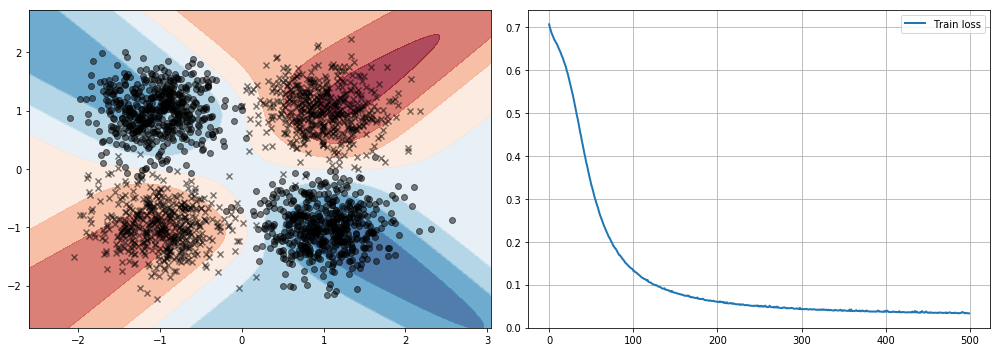

In [12]:
Z = net.forward(torch.from_numpy(np.c_[xx.ravel(), yy.ravel()].astype('float32')))
Z = Z.detach().numpy().reshape(xx.shape)
fig = plt.figure(figsize=(14, 5))
ax = fig.add_subplot(1, 2, 1)
ax.contourf(xx, yy, Z, cmap=plt.cm.RdBu_r, alpha=0.75)
ax.scatter(data[labels==0, 0], data[labels==0, 1], color='k', marker='o', alpha=0.5)
ax.scatter(data[labels==1, 0], data[labels==1, 1], color='k', marker='x', alpha=0.5)
ax = fig.add_subplot(1, 2, 2)
ax.plot(running_loss, label='Train loss', linewidth=2)
#ax.plot(test_loss, label='Test loss', linewidth=2)
plt.grid()
plt.legend()
plt.tight_layout();